# Lightricks Challenge - DataHack 2018

In [1]:
import os
import sys
import operator
import numpy as np
import pandas as pd
import scipy
import dateutil
from sklearn.model_selection import train_test_split,KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import tree
from sklearn import linear_model
from sklearn import ensemble
import seaborn as sns
import matplotlib.pyplot as plt
import csv

In [2]:
path = './'
teamname = 'g452'
out_name = path + teamname + '_submission.csv'

In [3]:
df_usage = pd.read_csv(path + "train_usage_data.csv")

In [4]:
#Looking data format and types
df_usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263814 entries, 0 to 263813
Data columns (total 5 columns):
id                263814 non-null int64
feature_name      263814 non-null object
usage_duration    263814 non-null float64
end_use_date      263814 non-null object
accepted          263814 non-null bool
dtypes: bool(1), float64(1), int64(1), object(2)
memory usage: 8.3+ MB


The user population is all users who subscribed in April and **didn't** churn (cancel their subscription) within the seven first days after subscription.

The dataframe "df_usage" contains the user activity in the 7 first days after subscription.

The variables in dataframe "df_usage" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| feature_name | Name of feature used |
| usage_duration | Duration in seconds between feature was entered and accepted or canceled |
| end_use_date | Date and time when the feature use was ended (accepted or canceled) |
| accepted | True if the user accepted the changes by the feature and False if he did not accepted the changes |

In [5]:
df_usage.head()

,id,feature_name,usage_duration,end_use_date,accepted
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False


In [6]:
df_users = pd.read_csv(path + "train_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])

In [7]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6998 entries, 0 to 6997
Data columns (total 10 columns):
Unnamed: 0             6998 non-null int64
id                     6998 non-null int64
installation_date      6998 non-null datetime64[ns]
subscripiton_date      6998 non-null datetime64[ns]
country                6996 non-null object
initial_app_version    6998 non-null object
initial_ios_version    6998 non-null object
initial_device         6998 non-null object
days_until_churn       3220 non-null float64
churned                6998 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(3), object(4)
memory usage: 546.8+ KB


The variables in dataframe "df_users" are:

| Field name   | Description | 
|----------|-------------|
| id | User ID |
| installation_date | Date and time when the application was first installed |
| subscription_date | Date and time when the user joined as a subscriber |
| country | Country where the user is based |
| initial_app_version | The application version at the installation date |
| initial_ios_version | The iOS version at the installation date |
| initial_device |  Device model at the installation date |
| days_until_churned | Days before the user decided to leave the subscription (churn). NaN if the user has not churned at all by the date when the data was queried |
| churned | **False if the user is still a subscriber at day 28 and True if the user canceled his subscription between day 8 and day 28.** |

In [8]:
df_users = df_users.drop(columns='Unnamed: 0')
df_users.head()

,id,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,100000415577994,2017-07-16 22:29:31,2018-04-01 01:35:58,Canada,1.9.1,11.2.5,UIDeviceKindIPhoneX,NaN,0
1,100000415580508,2016-12-19 14:28:03,2018-04-01 01:45:40,New Zealand,1.7.5,11.2.1,UIDeviceKindIPhoneX,136.0,0
2,100000415636784,2017-02-09 00:48:33,2018-04-01 05:15:46,United States,1.6,10.3.3,UIDeviceKindIPhone6S,70.0,0
3,100000415750897,2017-12-07 16:03:47,2018-04-01 13:27:22,Turkey,1.9.5,11.2.6,UIDeviceKindIPhone5S,NaN,0
4,100000415825030,2017-12-01 14:59:29,2018-04-01 17:23:33,United States,1.9.5,11.2.6,UIDeviceKindIPhone8,9.0,1


# Data exploration:

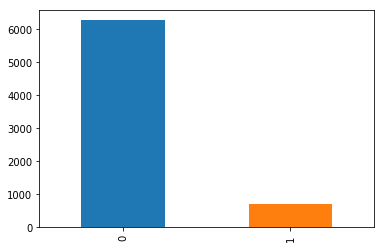

In [9]:
df_users['churned'].value_counts().plot('bar')

In [10]:
joined_df = df_usage.join(df_users.set_index('id'),on='id')

In [11]:
joined_df.head()

,id,feature_name,usage_duration,end_use_date,accepted,installation_date,subscripiton_date,country,initial_app_version,initial_ios_version,initial_device,days_until_churn,churned
0,30000429392689,Relight,5.659,2018-04-10 11:18:16,False,2018-02-26 07:01:08,2018-04-08 09:38:19,Australia,1.9.6,11.2.6,UIDeviceKindIPhoneX,NaN,0
1,440000407817536,Crop,0.984,2018-04-06 16:44:19,False,2017-07-21 20:04:15,2018-04-05 22:39:32,United Kingdom,1.9.6,11.2.5,UIDeviceKindIPhoneX,NaN,0
2,540000265662400,Crop,1.583,2018-04-21 18:46:24,False,2018-04-21 02:01:23,2018-04-21 02:14:14,United States,1.9.6,11.2,UIDeviceKindIPhone8,NaN,0
3,220000444951653,Vignette,4.668,2018-04-30 14:11:22,False,2018-04-30 12:45:44,2018-04-30 12:57:44,Australia,1.9.6,11.2.5,UIDeviceKindIPhone7Plus,NaN,0
4,220000444725338,Retouch,185.154,2018-04-29 23:37:34,False,2018-04-29 21:14:23,2018-04-29 22:07:56,United States,1.9.6,11.2.6,UIDeviceKindIPhone6Plus,31.0,0


Text(0.5, 1.0, 'Most used features, churned=0')

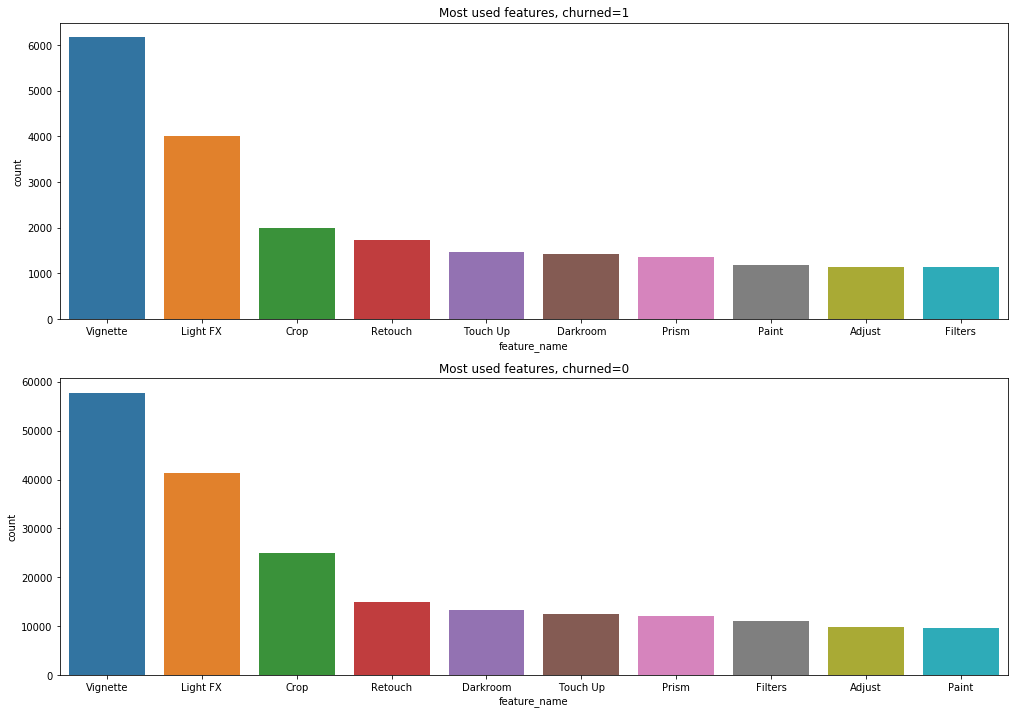

In [12]:
#What are the most popular features, within each class:

total_number_of_usage_per_feature = df_usage['feature_name'].value_counts()



k = 10
top_k_features_churned = joined_df[joined_df['churned']==True]['feature_name'].value_counts().index[:k]
top_k_features_not_churned = joined_df[joined_df['churned']==False]['feature_name'].value_counts().index[:k]


fig, ax = plt.subplots(2,1, figsize=(17,12))
df_churned = joined_df[joined_df['churned']==True]
p = sns.countplot(data=df_churned[df_churned['feature_name'].isin(top_k_features_churned)], x='feature_name', order = top_k_features_churned, ax=ax[0])

df_not_churned = joined_df[joined_df['churned']==False]
q = sns.countplot(data=df_not_churned[df_not_churned['feature_name'].isin(top_k_features_not_churned)], x='feature_name', order = top_k_features_not_churned, ax=ax[1])

ax[0].set_title('Most used features, churned=1')
ax[1].set_title('Most used features, churned=0')

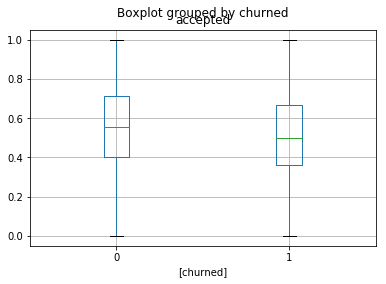

In [13]:
joined_df.groupby(['id', 'churned'])[['accepted']].mean().boxplot(by='churned')

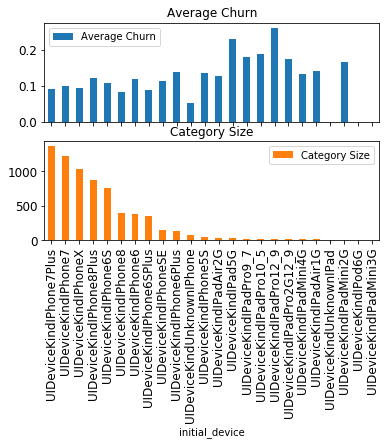

In [14]:
#device analysis: ipad users are more likely to churn
grouped = df_users.groupby(['initial_device'])
avg_churn = grouped.agg({'churned' : 'mean', 'id' : 'count'})
avg_churn.rename(columns={'churned' : 'Average Churn', 'id' : 'Category Size'}, inplace=True)
avg_churn.sort_values('Category Size', ascending=False).plot.bar(subplots=True, fontsize=12);

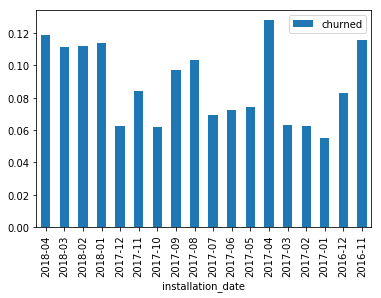

In [15]:
#user seniority analysis (based on installation date): users intalled app in 2018 are more likely to churn
user_seniority = df_users.loc[:,('id','churned','installation_date')]
user_seniority['installation_date'] = user_seniority.installation_date.dt.to_period('M')
user_seniority = user_seniority.groupby('installation_date')['churned'].mean().to_frame()
user_seniority.sort_values('installation_date', ascending=False).plot.bar(subplots=False);

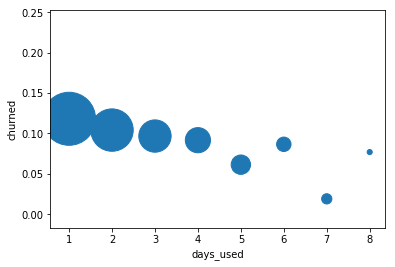

In [16]:
#Daily usage analysis: the more days the app is used - the user is likely to stay
def analyze_daily_engagement(_df_usage):
    user_engagement = _df_usage.loc[:,('id','end_use_date')]
    user_engagement['end_use_date'] = pd.to_datetime(user_engagement['end_use_date'])
    user_engagement['end_use_date'] = user_engagement.end_use_date.dt.to_period('D')
    user_engagement.drop_duplicates(inplace=True)
    daily_engagement = user_engagement.groupby(['id'])['end_use_date'].count().to_frame().reset_index()
    daily_engagement.rename(columns={'end_use_date' : 'days_used'}, inplace=True)
    return daily_engagement

user_daily_engagement = analyze_daily_engagement(df_usage)
user_daily_engagement = user_daily_engagement.merge(df_users.set_index('id')[['churned']], on='id')
grouped = user_daily_engagement.groupby(['days_used'])
mean_churn = grouped['churned'].mean().reset_index()
group_size = grouped['id'].count().to_frame()
mean_churn.plot.scatter(x='days_used', y='churned', s=group_size, rot=1);

2616 users didn't use crop. Their churn mean rate is 0.09671253822629969
11 users didn't use any feature, but crop. Their churn mean rate is 0.09090909090909091


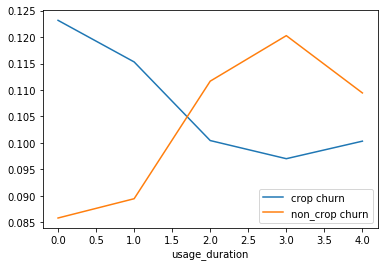

In [17]:
# usage duration analysis:
# users spending more time on features tend to churn, except crop.
def analyze_usage_duration(_df_usage, bins=None):
    usage_duration = _df_usage.loc[:,('id','usage_duration')]
    usage_duration = usage_duration.groupby(['id'])['usage_duration'].quantile(0.75).to_frame()
    if bins is None:
        return pd.qcut(usage_duration['usage_duration'], 5, retbins=True, labels=False)
    else:
        return pd.cut(usage_duration['usage_duration'], bins=bins, labels=False, include_lowest=True)

def create_mean_churn_by_usage_duration(_user_usage_duration, feature_name):
    _user_usage_duration = _user_usage_duration.to_frame().merge(df_users.set_index('id')[['churned']], on='id')
    _user_usage_duration = _user_usage_duration.groupby(['usage_duration'])['churned'].mean().reset_index()
    _user_usage_duration.rename(columns={'churned' : feature_name + ' churn'}, inplace=True)
    return _user_usage_duration

crop_usage_duration, crop_bins = analyze_usage_duration(df_usage[(df_usage.feature_name=='Crop')])
non_crop_usage_duration, non_crop_bins = analyze_usage_duration(df_usage[(df_usage.feature_name!='Crop')])

churn_by_crop_usage_duration = create_mean_churn_by_usage_duration(crop_usage_duration, 'crop').set_index('usage_duration')
churn_by_non_crop_usage_duration = create_mean_churn_by_usage_duration(non_crop_usage_duration, 'non_crop').set_index('usage_duration')
churn_by_usage_duration = churn_by_crop_usage_duration.join(churn_by_non_crop_usage_duration, on='usage_duration', how='left')
churn_by_usage_duration.plot.line()

# also examine what is the churn rate of users not using those features
users_not_using_crop = df_users.set_index('id').drop(crop_usage_duration.index)
print("{0} users didn't use crop. Their churn mean rate is {1}".format(len(users_not_using_crop.index), users_not_using_crop['churned'].mean()))
users_using_only_crop = df_users.set_index('id').drop(non_crop_usage_duration.index)
print("{0} users didn't use any feature, but crop. Their churn mean rate is {1}".format(len(users_using_only_crop.index), users_using_only_crop['churned'].mean()))

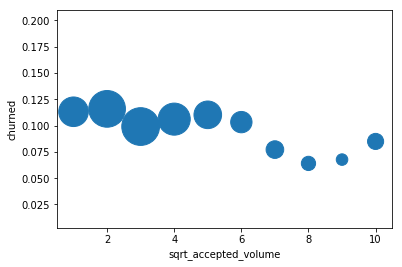

In [18]:
# usage volume analysis: users with accepted volume of 40-100 seem to churn less
def analyze_usage_volume(_df_usage):
    accepted = _df_usage[(_df_usage.accepted==True)]
    accepted_volume = accepted.groupby(['id']).accepted.count().to_frame()
    accepted_volume['accepted'] = accepted_volume.apply(np.sqrt, axis=1)
    accepted_volume['accepted'] = accepted_volume.apply(np.round, axis=1).clip(1,10)
    return accepted_volume.rename(columns={'accepted' : 'sqrt_accepted_volume'})
    
accepted_volume = analyze_usage_volume(df_usage)
accepted_volume = accepted_volume.merge(df_users.set_index('id')[['churned']], on='id')
grouped = accepted_volume.groupby(['sqrt_accepted_volume'])
churn_rate_by_accepted_volume = grouped.churned.mean().to_frame().reset_index()
group_size = grouped.sqrt_accepted_volume.count()
churn_rate_by_accepted_volume.plot.scatter(x='sqrt_accepted_volume', y='churned', s=group_size, rot=1);

# Creating our input data:

In [19]:
#Let's create a table with statistic summaries: rows correspond to users; columns to various statistics:
def is_ipad(device):
    return 1 if device.startswith('UIDeviceKindIPad') else 0

def user_seniority(installation_date):
    from datetime import datetime
    from dateutil import relativedelta
    seniority = relativedelta.relativedelta(datetime.strptime(str('2018-04-01'),'%Y-%m-%d'), installation_date)
    return seniority.months

def prepare_features(_df_users, _df_usage, _user_daily_engagement=None):
    features = pd.pivot_table(_df_usage[['id', 'feature_name']], index=['id'], columns=['feature_name'], aggfunc=len, fill_value=0)
    
    #Let's add the mean of 'accepted' for each user:
    accepted_rate = _df_usage.groupby(['id'])['accepted'].mean().to_frame()
    features = features.join(accepted_rate, how='left')
    
    #add iphone/ipad users:
    _df_users['is_ipad_device'] = _df_users['initial_device'].apply(is_ipad)
    _df_users['user_seniority'] = _df_users['installation_date'].apply(user_seniority)
    features = features.merge(_df_users.set_index('id')[['is_ipad_device','user_seniority']], on='id', how='left')
    
    #add user daily engagement:
    if _user_daily_engagement is None:
        _user_daily_engagement = analyze_daily_engagement(_df_usage)
    features = features.merge(_user_daily_engagement.set_index('id')[['days_used']], on='id', how='left')
    
    #add user's usage duration for crop and non-crop (bucket, not the actual duration)
    crop_usage_duration = analyze_usage_duration(_df_usage[(_df_usage.feature_name=='Crop')], crop_bins).to_frame()
    crop_usage_duration.rename(columns={'usage_duration':'crop_usage_duration'}, inplace=True)
    features = features.merge(crop_usage_duration[['crop_usage_duration']], on='id', how='left')
    features.fillna(4, inplace=True)
    non_crop_usage_duration = analyze_usage_duration(_df_usage[(_df_usage.feature_name!='Crop')], non_crop_bins).to_frame()
    non_crop_usage_duration.rename(columns={'usage_duration':'non_crop_usage_duration'}, inplace=True)
    features = features.merge(non_crop_usage_duration[['non_crop_usage_duration']], on='id', how='left')
    features.fillna(0, inplace=True)
    
    #add user's usage volume
    features = features.merge(analyze_usage_volume(df_usage), on='id', how='left')
    features.fillna(0, inplace=True)
    
    return features

users_usage_summaries = prepare_features(df_users, df_usage, user_daily_engagement)

#Add churn label to the training data
users_usage_summaries = users_usage_summaries.merge(df_users.set_index('id')[['churned']], on='id', how='left')

#This is how our df looks like:
users_usage_summaries.head(10)


,Adjust,Backdrop,Crop,Darkroom,Defocus,Eyes,Face,Filters,Light FX,Paint,...,Touch Up,Vignette,accepted,is_ipad_device,user_seniority,days_used,crop_usage_duration,non_crop_usage_duration,sqrt_accepted_volume,churned
id,,,,,,,,,,,,,,,,,,,,,
20000443246052,1,0,14,2,1,1,0,0,17,6,...,3,25,0.600000,0,4,6,2.0,1.0,7.0,0
20000443252617,2,2,0,7,0,0,0,0,16,1,...,3,14,0.409836,0,2,5,4.0,2.0,5.0,0
20000443310150,2,0,0,9,0,3,1,0,3,1,...,0,3,0.290323,0,0,1,4.0,4.0,3.0,0
20000443367561,0,0,0,0,0,0,0,0,1,0,...,0,0,1.000000,0,0,1,4.0,4.0,1.0,0
20000443405819,0,0,0,0,0,0,0,0,0,0,...,0,3,0.500000,0,7,1,4.0,4.0,1.0,0
20000443434193,0,0,0,0,0,0,0,0,1,0,...,0,3,0.750000,0,0,1,4.0,3.0,2.0,0
20000443469779,12,7,7,2,0,6,4,1,21,4,...,7,11,0.700000,0,5,2,4.0,3.0,8.0,0
20000443895994,0,0,2,0,1,0,2,0,27,1,...,7,11,0.507692,0,0,6,1.0,1.0,6.0,0
20000444138744,1,0,0,0,0,0,1,1,4,0,...,3,9,0.600000,0,0,1,4.0,4.0,3.0,1


# Learn a decision tree:

In [20]:
X = users_usage_summaries.iloc[:, users_usage_summaries.columns!='churned'].values
y = users_usage_summaries.loc[:,'churned'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.1)

In [21]:
# algo=tree.DecisionTreeClassifier(class_weight='balanced', max_depth=3, min_samples_split=5, min_samples_leaf=2, random_state=0)
algo=ensemble.RandomForestClassifier(class_weight='balanced', n_estimators=500, max_depth=3, random_state=0)
train = algo.fit(X_train, y_train)
res=train.predict(X_val)
algo.feature_importances_

array([0.02264805, 0.02018631, 0.11031204, 0.01887007, 0.02126063,
       0.01811435, 0.024868  , 0.02565987, 0.09180838, 0.0353023 ,
       0.00168246, 0.01630039, 0.03699762, 0.02646633, 0.0398704 ,
       0.02217792, 0.0379448 , 0.1638048 , 0.01113994, 0.07809778,
       0.076544  , 0.01902685, 0.04362326, 0.03729344])

In [22]:
#Let's check the confusion matrix:
cm = metrics.confusion_matrix(y_val, res)
print(cm)
res_train = train.predict(X_train)
print(classification_report(y_pred=res_train,y_true=y_train))
print(classification_report(y_pred=res,y_true=y_val))
# print only f1 score for positive
print(np.round(f1_score(y_pred=res,y_true=y_val),5))

[[344 280]
 [ 29  47]]
              precision    recall  f1-score   support

           0       0.94      0.57      0.71      5651
           1       0.15      0.66      0.24       647

   micro avg       0.58      0.58      0.58      6298
   macro avg       0.54      0.61      0.47      6298
weighted avg       0.85      0.58      0.66      6298

              precision    recall  f1-score   support

           0       0.92      0.55      0.69       624
           1       0.14      0.62      0.23        76

   micro avg       0.56      0.56      0.56       700
   macro avg       0.53      0.58      0.46       700
weighted avg       0.84      0.56      0.64       700

0.23325


In [23]:
#test your predictor:

#1.Prepare your test-set (in case you created new features/transformed the input data):
df_usage_test = pd.read_csv("test_usage_data.csv")
df_users_test = pd.read_csv(path + "test_users_data.csv",parse_dates = [ 'installation_date','subscripiton_date'])
df_users_test = df_users_test.drop(columns='Unnamed: 0')

#prepare the feaures as in the training set
users_usage_summaries_test = prepare_features(df_users_test, df_usage_test)

X_test = users_usage_summaries_test.values

In [24]:
#submit result:
pred = train.predict(X_test)
df = pd.DataFrame(pred, index=users_usage_summaries_test.index.astype(str), columns=['churned'], dtype=str)
df.to_csv(out_name, header=True, quoting=csv.QUOTE_NONNUMERIC) 